In [ ]:
# import libs
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Activation, Add, Dense, Conv2D, MaxPool2D, AveragePooling2D, BatchNormalization, Input, ZeroPadding2D, AveragePooling2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
from keras.applications import vgg16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Flatten
import random
import os

###1. Implement lại mô hình resnet, dùng mô hình đấy train với dữ liệu cifar-10.

In [ ]:
# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
# parameters
NUM_CLASSES = np.unique(y_train).shape[0]
BATCH_SIZE = 32
EPOCHS = 50
COLORS = 3

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=10_000)

print('Train size: \t', x_train.shape[0])
print('Val size: \t', x_val.shape[0])
print('Test size: \t', x_test.shape[0])

Train size: 	 40000
Val size: 	 10000
Test size: 	 10000


In [ ]:
# normalize input
x_train = x_train / 255.
x_test = x_test / 255.
x_val = x_val / 255.

# One-hot
y_test = np_utils.to_categorical(y_test, NUM_CLASSES)
y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
y_val = np_utils.to_categorical(y_val, NUM_CLASSES)

print(y_test[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [ ]:
# define residual block
# X: input
# filters: filter size array
def residual_block(X, filters, isPooling=False):
  # save a copy
  X_copy = X

  num_layers = len(filters)

  stride = (1, 1)

  if isPooling:
    stride = (2, 2)

  # first layers
  X = ZeroPadding2D((1, 1))(X)
  X = Conv2D(filters[0], (3, 3), padding='valid', strides=stride)(X)
  # N * H * W * D
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  # iterate each layer
  for i in range(1, num_layers - 1):
    X = Conv2D(filters[i], (3, 3), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

  # last layer
  X = Conv2D(filters[-1], (3, 3), padding='same')(X)
  X = BatchNormalization(axis=3)(X)

  # resize x_copy if needed
  if isPooling:
    X_copy = Conv2D(filters[-1], (1, 1), strides=stride, padding='same')(X_copy)
    X_copy = BatchNormalization(axis=3)(X_copy)

  # add x
  X = Add()([X, X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# define ResNet model
def ResNet(input_shape, num_classes):
  
  # input
  X_input = Input(input_shape)

  # padding before convolution
  X = ZeroPadding2D((3, 3))(X_input)

  # first stage
  X = Conv2D(64, (3, 3), strides=(2, 2))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPool2D()(X)

  # residual block
  X = residual_block(X, [64, 64, 64], False)
  X = residual_block(X, [64, 64, 64], False)
  X = residual_block(X, [64, 64, 64], False)

  X = residual_block(X, [128, 128, 128], True)

  X = residual_block(X, [128, 128, 128], False)
  X = residual_block(X, [128, 128, 128], False)

  # final stage
  X = AveragePooling2D()(X)

  # Output layer
  X = Flatten()(X)
  
  X = Dropout(0.4)(X)
  X = Dense(256, activation='relu')(X)
  X = Dropout(0.4)(X)
  X = Dense(128, activation='relu')(X)
  X = Dropout(0.4)(X)
  X = Dense(num_classes, activation='softmax')(X)

  # Build model
  model = Model(inputs=X_input, outputs=X, name='CustomResNet')

  return model

In [ ]:
# data shape
x_train[0].shape

(32, 32, 3)

In [ ]:
model = ResNet(input_shape=(32, 32, 3), num_classes=NUM_CLASSES)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "CustomResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_56 (ZeroPadding2 (None, 38, 38, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_160 (Conv2D)             (None, 18, 18, 64)   1792        zero_padding2d_56[0][0]          
__________________________________________________________________________________________________
batch_normalization_160 (BatchN (None, 18, 18, 64)   256         conv2d_160[0][0]                 
_______________________________________________________________________________________

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
H = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val), verbose=1, callbacks=[es])

Epoch 1/50
1250/1250 [==============================] - 24s 15ms/step - loss: 2.1428 - accuracy: 0.2327 - val_loss: 1.5963 - val_accuracy: 0.4228
Epoch 2/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.4608 - accuracy: 0.4798 - val_loss: 1.6170 - val_accuracy: 0.4433
Epoch 3/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.2221 - accuracy: 0.5787 - val_loss: 1.2435 - val_accuracy: 0.5672
Epoch 4/50
1250/1250 [==============================] - 17s 14ms/step - loss: 1.0571 - accuracy: 0.6430 - val_loss: 1.2442 - val_accuracy: 0.5826
Epoch 5/50
1250/1250 [==============================] - 16s 13ms/step - loss: 0.9313 - accuracy: 0.6849 - val_loss: 0.9802 - val_accuracy: 0.6643
Epoch 6/50
1250/1250 [==============================] - 17s 13ms/step - loss: 0.8276 - accuracy: 0.7225 - val_loss: 0.9708 - val_accuracy: 0.6669
Epoch 7/50
1250/1250 [==============================] - 16s 13ms/step - loss: 0.7424 - accuracy: 0.7546 - val_loss: 0.9249 -

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.8432479500770569
Test accuracy:  0.7560999989509583


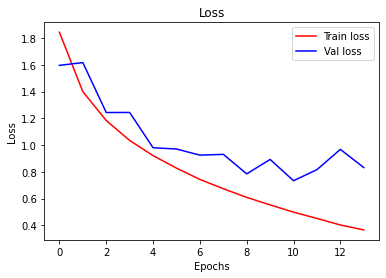

In [ ]:
# Loss
plt.plot(H.history['loss'], 'r-')
plt.plot(H.history['val_loss'], 'b-')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train loss', 'Val loss'])
plt.show()

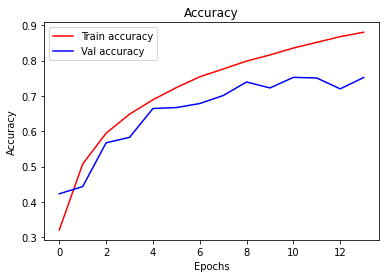

In [ ]:
# Accuracy
plt.plot(H.history['accuracy'], 'r-')
plt.plot(H.history['val_accuracy'], 'b-')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.show()

###2. Đọc, hiểu code phần feature extractor và fine-tune trong code mẫu, dataset lấy ở đây https://github.com/nttuan8/DL_Tutorial/tree/master/L9..., để hiểu việc dùng pre-trained model, augmentation.

**Feature extractor**

In [ ]:
%cd '/content/drive/MyDrive/The Anh Tran/HW5'
!ls

/content/drive/.shortcut-targets-by-id/1iTl5EvhAkwEQhbz8P_bIGaNXAYESafQ8/The Anh Tran/HW5
dataset  Homework5-Techniques.ipynb


In [ ]:
# Lấy đường đẫn tới ảnh
image_path = list(paths.list_images('dataset/'))

# Đổi vị trí
random.shuffle(image_path)

In [ ]:
image_path

['dataset/Crocus/image_0325.jpg',
 'dataset/Daisy/image_0830.jpg',
 'dataset/Tigerlily/image_0530.jpg',
 'dataset/Dandelion/image_1003.jpg',
 'dataset/Dandelion/image_0994.jpg',
 'dataset/Tulip/image_0636.jpg',
 'dataset/Daffodil/image_0008.jpg',
 'dataset/Windflower/image_1203.jpg',
 'dataset/ColtsFoot/image_0913.jpg',
 'dataset/Fritillary/image_0709.jpg',
 'dataset/ColtsFoot/image_0950.jpg',
 'dataset/LilyValley/image_0176.jpg',
 'dataset/LilyValley/image_0227.jpg',
 'dataset/Pansy/image_1360.jpg',
 'dataset/Tulip/image_0624.jpg',
 'dataset/Sunflower/image_0759.jpg',
 'dataset/Tigerlily/image_0512.jpg',
 'dataset/Buttercup/image_1167.jpg',
 'dataset/Daisy/image_0834.jpg',
 'dataset/ColtsFoot/image_0892.jpg',
 'dataset/Windflower/image_1226.jpg',
 'dataset/Daisy/image_0812.jpg',
 'dataset/Windflower/image_1213.jpg',
 'dataset/ColtsFoot/image_0910.jpg',
 'dataset/Windflower/image_1218.jpg',
 'dataset/Bluebell/image_0270.jpg',
 'dataset/Tulip/image_0599.jpg',
 'dataset/Sunflower/image_0

In [ ]:
# Lấy nhãn từ đường dẫn
labels = [p.split(os.path.sep)[-2] for p in image_path]

# Chuyển tên các loài hoa thành số
le = LabelEncoder()
labels = le.fit_transform(labels)

In [ ]:
labels

array([ 4,  6, 14, ...,  2, 13, 15])

In [ ]:
# load model VGG16 của ImageNet dataset, include_top = False để bỏ phần Fully connected layer ở cuối
model = vgg16.VGG16(weights='imagenet', include_top=False)

In [ ]:
# load ảnh và resize về đúng kích thước mà VGG16 cần là (224, 224)
list_image = []
for (j, imagePath) in enumerate(image_path):
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)       # shape = (224, 224, 3)
  
  image = np.expand_dims(image, 0)  # shape = (1, 224, 224, 3)
  image = imagenet_utils.preprocess_input(image)

  list_image.append(image)

list_image = np.vstack(list_image)  # convert to numpy array

In [ ]:
list_image.shape

(1360, 224, 224, 3)

In [ ]:
# Lấy các feature trong ảnh bằng pre-trained model
features = model.predict(list_image, verbose=1)
print(features.shape)

# Flatten
features = features.reshape((features.shape[0], 512*7*7))
print(features.shape)

43/43 [==============================] - 6s 133ms/step
(1360, 7, 7, 512)
(1360, 25088)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# Grid search để tìm các parameter tốt nhất cho model. C = 1/lamda, hệ số trong regulation. Solver là kiểu optimizer
params = {'C' : [0.1, 1.0, 10.0, 100.0]} # L2 C = 1 / alpha
model = GridSearchCV(LogisticRegression(max_iter=1000), params)
model.fit(X_train, y_train)
print('Best parameter for model: {}'.format(model.best_params_))

Best parameter for model: {'C': 100.0}


In [ ]:
# Đánh giá model
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       0.90      0.86      0.88        21
           2       1.00      0.79      0.88        19
           3       0.68      1.00      0.81        15
           4       0.93      0.88      0.90        16
           5       0.92      1.00      0.96        11
           6       1.00      0.91      0.95        11
           7       0.83      0.94      0.88        16
           8       1.00      0.93      0.97        15
           9       1.00      0.88      0.93        16
          10       0.88      1.00      0.94        15
          11       1.00      0.92      0.96        12
          12       0.88      0.94      0.91        16
          13       0.90      1.00      0.95        19
          14       1.00      0.88      0.93        16
          15       0.95      0.83      0.89        24
          16       0.94      0.83      0.88        18

    accuracy              

**Fine-tunning**

In [ ]:
%cd '/content/drive/MyDrive/The Anh Tran/HW5'
!ls

/content/drive/.shortcut-targets-by-id/1iTl5EvhAkwEQhbz8P_bIGaNXAYESafQ8/The Anh Tran/HW5
dataset  Homework5-Techniques.ipynb


In [ ]:
image_path = list(paths.list_images('dataset/'))
random.shuffle(image_path)

In [ ]:
labels = [p.split(os.path.sep)[-2] for p in image_path]

# convert to number
le = LabelEncoder()
labels = le.fit_transform(labels)

# conver to one-hot
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
list_image = []
for (j, imagePath) in enumerate(image_path):
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)

  image = np.expand_dims(image, 0)
  image = imagenet_utils.preprocess_input(image)

  list_image.append(image)

list_image = np.vstack(list_image)

In [ ]:
# Tương tự, ta cũng có list_image như phần trên
list_image.shape

(1360, 224, 224, 3)

In [ ]:
# Load model VGG16 của ImageNet datasetm bỏ phần Fully Connected
baseModel = vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
# xây thêm các layer
# Lấy output từ ConvNet trong VGG16
fcHead = baseModel.output

# flatten trước khi đưa vào FC
fcHead = Flatten()(fcHead)

# Thêm FC
fcHead = Dense(256, activation='relu')(fcHead)
fchead = Dropout(0.5)(fcHead)

# Output
fcHead = Dense(17, activation='softmax')(fcHead)

# build model
model = Model(inputs=baseModel.inputs, outputs=fcHead)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Chia training - test tỉ lệ 80 - 20
X_train, X_test, y_train, y_test = train_test_split(list_image, labels, test_size=0.2, random_state=42)

In [ ]:
# augmentation for training data
aug_train = ImageDataGenerator(rescale=1./255, 
                               rotation_range=30, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.2, 
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')

# augmentation for test
aug_test = ImageDataGenerator(rescale=1./255) # chuẩn hóa về khoản 0, 1

In [ ]:
# freeze VGG model
for layer in baseModel.layers:
  layer.trainable = False

opt = RMSprop(0.001)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
numOfEpochs = 15
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32),
                        steps_per_epoch=len(X_train)//32,
                        validation_data = (aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpochs)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
34/34 [==============================] - 18s 460ms/step - loss: 11.4055 - accuracy: 0.1422 - val_loss: 1.7326 - val_accuracy: 0.4648
Epoch 2/15
34/34 [==============================] - 15s 441ms/step - loss: 1.7488 - accuracy: 0.4773 - val_loss: 1.1502 - val_accuracy: 0.6172
Epoch 3/15
34/34 [==============================] - 15s 442ms/step - loss: 1.3538 - accuracy: 0.6014 - val_loss: 0.8353 - val_accuracy: 0.7305
Epoch 4/15
34/34 [==============================] - 15s 442ms/step - loss: 0.9149 - accuracy: 0.7145 - val_loss: 1.0392 - val_accuracy: 0.6484
Epoch 5/15
34/34 [==============================] - 15s 441ms/step - loss: 0.8385 - accuracy: 0.7225 - val_loss: 0.6438 - val_accuracy: 0.7773
Epoch 6/15
34/34 [==============================] - 15s 438ms/step - loss: 0.5616 - accuracy: 0.8372 - val_loss: 0.3387 - val_accuracy: 0.8789
Epoch 7/15
34/34 [==============================] - 15s 441ms/step - loss: 0.4509 - accuracy: 0.8556 - val_loss: 0.6871 - val_accuracy: 0.800

In [ ]:
# unfreeze some last layer
for layer in baseModel.layers[15:]:
  layer.trainable = True

numOfEpochs = 15
opt = SGD(0.001)
model.compile(opt, 'categorical_crossentropy', ['accuracy'])
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32),
                        steps_per_epoch = len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpochs)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
34/34 [==============================] - 17s 468ms/step - loss: 0.1076 - accuracy: 0.9698 - val_loss: 0.1917 - val_accuracy: 0.9297
Epoch 2/15
34/34 [==============================] - 15s 448ms/step - loss: 0.0384 - accuracy: 0.9887 - val_loss: 0.1935 - val_accuracy: 0.9297
Epoch 3/15
34/34 [==============================] - 16s 455ms/step - loss: 0.0252 - accuracy: 0.9911 - val_loss: 0.2355 - val_accuracy: 0.9258
Epoch 4/15
34/34 [==============================] - 16s 456ms/step - loss: 0.0262 - accuracy: 0.9939 - val_loss: 0.1848 - val_accuracy: 0.9414
Epoch 5/15
34/34 [==============================] - 16s 454ms/step - loss: 0.0247 - accuracy: 0.9928 - val_loss: 0.2065 - val_accuracy: 0.9297
Epoch 6/15
34/34 [==============================] - 16s 455ms/step - loss: 0.0155 - accuracy: 0.9986 - val_loss: 0.1847 - val_accuracy: 0.9375
Epoch 7/15
34/34 [==============================] - 15s 453ms/step - loss: 0.0243 - accuracy: 0.9951 - val_loss: 0.1811 - val_accuracy: 0.9492